<a href="https://colab.research.google.com/github/harnalashok/LLMs/blob/main/asyncio_await.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 7th April, 2025


# Asyncio and concepts

## How does python do multiple processing at once?

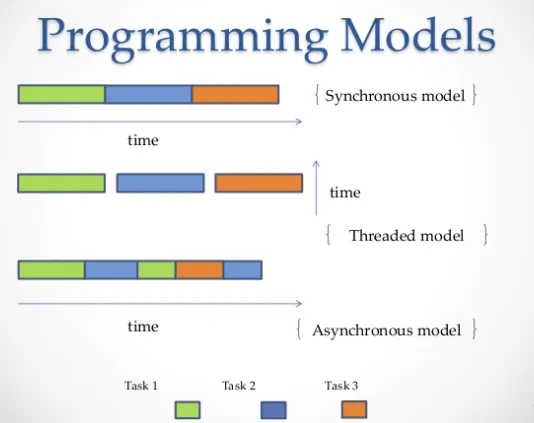

### Multiple processes

>The most obvious way is to use multiple processes. From the terminal, you can start your script two, three, four…ten times and then all the scripts are going to run independently or at the same time. The operating system that’s underneath will take care of sharing your CPU resources among all those instances. Alternately you can use the multiprocessing library which supports spawning processes

### Multiple threads

>The next way to run multiple things at once is to use threads. A thread is a line of execution, pretty much like a process, but you can have multiple threads in the context of one process and they all share access to common resources.
>> A classic example of multiple threads in action is a web browser, where one thread handles user interface updates while another thread downloads data for web pages, allowing for a responsive user experience even during downloads.    

>>Web Browsers:

 >>>One thread handles user interface (UI) interactions (e.g., scrolling, clicking buttons), while another thread downloads web pages in the background.

>>> Multiple threads can load different tabs or handle different downloads concurrently.

>>Word Processors:    

>>> One thread handles user input and displays the document, while another thread performs spell-checking or formatting in the background.

>>> Another thread might be used to generate a PDF version of the document.



## Async IO Explained
See [here](https://realpython.com/async-io-python/#async-io-explained)

Async IO may at first seem counterintuitive and paradoxical. How does something that facilitates concurrent code use a single thread and a single CPU core? I’ve never been very good at conjuring up examples, so I’d like to paraphrase one from Miguel Grinberg’s 2017 PyCon talk, which explains everything quite beautifully:

### Chess and async



>Chess master Judit Polgár hosts a chess exhibition in which she plays multiple amateur players. She has two ways of conducting the exhibition: synchronously and asynchronously.

>**Assumptions**:

>>    24 opponents   
    Judit makes each chess move in 5 seconds   
    Opponents each take 55 seconds to make a move   
    Games average 30 pair-moves (60 moves total)   

>**Synchronous version**: Judit plays one game at a time, never two at the same time, until the game is complete. Each game takes (55 + 5) * 30 == 1800 seconds, or 30 minutes. The entire exhibition takes 24 * 30 == 720 minutes, or 12 hours.

>**Asynchronous version**: Judit moves from table to table, making one move at each table. She leaves the table and lets the opponent make their next move during the wait time. One move on all 24 games takes Judit 24 * 5 == 120 seconds, or 2 minutes. The entire exhibition is now cut down to 120 * 30 == 3600 seconds, or just 1 hour.

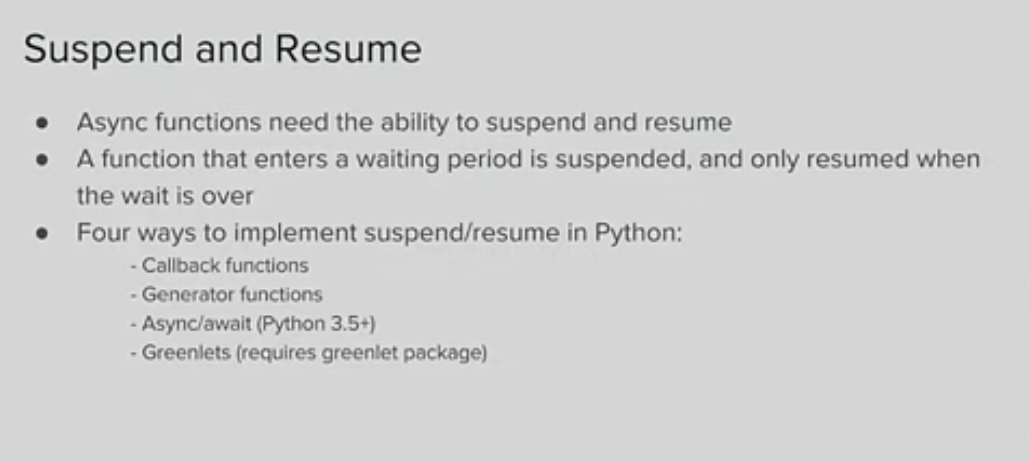

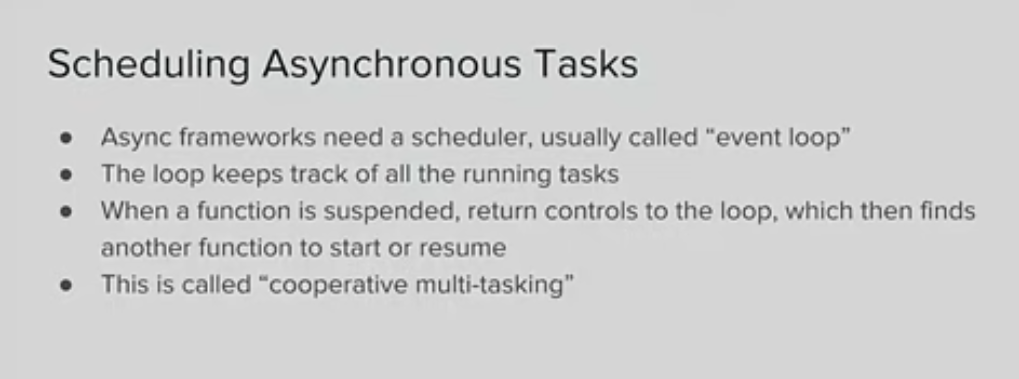

## The Basics of Asyncio
Refer [here](https://docs.llamaindex.ai/en/stable/getting_started/async_python/#1-the-basics-of-asyncio)

>**Event Loop**: The event loop handles the scheduling and execution of async operations. It continuously checks for and executes tasks (coroutines). All async operations run by this loop, and there can only be one event loop per thread.

>**asyncio.run()**: This function is the entry point for running an asynchronous program. It creates and manages the event loop and cleans up after it completes. Remember that it is designed to be called once per thread. Some frameworks like FastAPI will run the event loop for you, others will require you to run it yourself.

>**Async + Python Notebooks**: Python notebooks are a special case where the event loop is already running. This means you don't need to call asyncio.run() yourself, and can directly call and await async functions.


##  Async Functions and await
Refer [here](https://docs.llamaindex.ai/en/stable/getting_started/async_python/#2-async-functions-and-await)

>**Defining Async Functions**: Use the async def syntax to define an asynchronous function (coroutine). Instead of executing immediately, calling an async function returns a coroutine object that needs to be scheduled and run.

>**Using await**: Inside an async function, await is used to pause execution of that function until the awaited task is complete. When you write await some_fn(), *the function yields control back to the event loop* so that other tasks can be scheduled and run. Only one async function executes at a time, and they cooperate by yielding with await.


## Concurrency Explained

>**Cooperative Concurrency**: Although you can schedule multiple async tasks, only one task runs at a time. This is different from true parallelism, where multiple tasks run at the same time. When a task hits an await, it suspends its execution so that another task may run. This makes async programs excellent for I/O-bound tasks where waiting is common, such as API calls to LLMs and other services.

>**Not True Parallelism**: Asyncio enables concurrency but does not run tasks in parallel. For CPU-bound work requiring parallel execution, consider threading or multiprocessing. LlamaIndex typically avoids multiprocessing in most cases, and leaves it up to the user to implement, as it can be complex to do so in a way that is safe and efficient.


## Coroutines
See [here](https://docs.python.org/3/library/asyncio-task.html#coroutines-and-tasks)

Coroutines declared with the `async/await` syntax is the preferred way of writing `asyncio` applications. For example, the following snippet of code prints “hello”, waits 1 second, and then prints “world”:

In [ ]:
import asyncio

# Define a coroutine
# Instructions in a coroutine always execute in sequence
async def main():
    print('hello')
    await asyncio.sleep(3)   # Return control to the event loop
                             #  to execute some other function/task
                             #   till time of 3 secs is passed then
                             #    begin executing this function and
                             #     maybe suspending the other one.
    print('world')



In [ ]:
# To execute in Visual Studio Code/ipython
# asyncio.run(main())

# To execute in jupyter notebook:
await main()


hello
world


Note that simply calling a coroutine **will not schedule** it to be executed:

In [ ]:
main()

<coroutine object main at 0x7f1a72f8e740>

To actually run a coroutine, asyncio provides the following mechanisms:

>1. The `asyncio.run()` function to run the top-level entry point “main()” function (see the above example.)

>2. Awaiting on a coroutine. The following snippet of code will print “hello” after waiting for 1 second, and then print “world” after waiting for another 2 seconds:

In [ ]:
import asyncio
import time

async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

async def main():
    print(f"started at {time.strftime('%X')}")

    await say_after(1, 'hello')      # Control return back to Event scheduler
                                     #  but event scheduler has no other coroutine
                                     #   to execute--so wait 1 sec
    await say_after(2, 'world')      # Wait again 2 secs

    print(f"finished at {time.strftime('%X')}")

In [ ]:
# asyncio.run(main())
await main()

started at 08:27:05
hello
world
finished at 08:27:08


>3. The `asyncio.create_task()` function to run coroutines concurrently as `asyncio` Tasks. `create_task()` puts all async functions in an event scheduler.

Let’s modify the above example and run the two `say_after()` coroutines concurrently:

The function, `asyncio.create_task(coro, *, name=None, context=None)`, wraps the *coro* coroutine into a *Task* and *schedules* its execution. It returns the Task object.

In [ ]:
async def main():
    # Create task1 and put it in event loop to schdule its execution
    task1 = asyncio.create_task(
                                 say_after(1, 'hello')
                                )
    # Create task2 and put it in event loop to schdule its execution
    task2 = asyncio.create_task(
                                 say_after(2, 'world')
                                )

    print(f"started at {time.strftime('%X')}")

    # Wait until both tasks are completed (should take
    # around 2 seconds.)
    await task1
    await task2

    print(f"finished at {time.strftime('%X')}")

In [ ]:
# asyncio.run(main())
await main()

started at 08:45:03
hello
world
finished at 08:45:05


### gather()
See [here](https://docs.python.org/3/library/asyncio-task.html#running-tasks-concurrently)

 `awaitable asyncio.gather(*aws, return_exceptions=False)`

>Run awaitable objects in the *aws* sequence concurrently.

>If any awaitable in *aws* sequence is a coroutine, it is automatically scheduled as a Task.

>If all awaitables are completed successfully, the result is an aggregate list of returned values. The order of result values corresponds to the order of awaitables in *aws* sequence.

In [ ]:
import asyncio

async def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        print(f"Task {name}: Compute factorial({number}), currently i={i}...")
        await asyncio.sleep(1)
        f *= i
    print(f"Task {name}: factorial({number}) = {f}")
    return f

async def main():
    # Schedule three calls *concurrently*:
    L = await asyncio.gather(
                              factorial("A", 2),  # Schedule this task
                              factorial("B", 3),  # Schedule next task
                              factorial("C", 4),  # Schedule third task
                            )

    print(L)   # Print the list

#asyncio.run(main())

In [ ]:
await main()

Task A: Compute factorial(2), currently i=2...
Task B: Compute factorial(3), currently i=2...
Task C: Compute factorial(4), currently i=2...
Task A: factorial(2) = 2
Task B: Compute factorial(3), currently i=3...
Task C: Compute factorial(4), currently i=3...
Task B: factorial(3) = 6
Task C: Compute factorial(4), currently i=4...
Task C: factorial(4) = 24
[2, 6, 24]




**Note**

A new alternative to create and run tasks concurrently and wait for their completion is `asyncio.TaskGroup()`. `TaskGroup` provides stronger safety guarantees than gather for scheduling a nesting of subtasks: if a task (or a subtask, a task scheduled by a task) raises an exception, `TaskGroup` will, while `gather` will not, cancel the remaining scheduled tasks).

### Sleeping
See [here](https://docs.python.org/3/library/asyncio-task.html#sleeping)

 `async asyncio.sleep(delay, result=None)`

>Block for delay seconds.

>If result is provided, it is returned to the caller when the coroutine completes.

>`sleep()` always suspends the current task, allowing other tasks to run.

In [ ]:
import asyncio
import datetime

async def display_date():
    loop = asyncio.get_running_loop()
    end_time = loop.time() + 5.0
    while True:
        print(datetime.datetime.now())
        if (loop.time() + 1.0) >= end_time:
            break
        await asyncio.sleep(1)

#asyncio.run(display_date())
await display_date()

2025-04-06 09:46:59.535776
2025-04-06 09:47:00.538033
2025-04-06 09:47:01.539415
2025-04-06 09:47:02.540743
2025-04-06 09:47:03.542066


## Awaitables
See [here](https://docs.python.org/3/library/asyncio-task.html#awaitables)

We say that an object is an *awaitable* object if it can be used in an `await` expression. Many asyncio APIs are designed to accept awaitables.

There are three main types of awaitable objects: coroutines, Tasks, and Futures.

## Event loop
See [here](https://docs.python.org/3/library/asyncio-eventloop.html#event-loop)

> Add blockquote



### `asyncio.get_running_loop()`
See [here](https://docs.python.org/3/library/asyncio-eventloop.html#asyncio.get_running_loop)

>Returns the running event loop in the current OS thread.

>Raises a RuntimeError if there is no running event loop.

>This function can only be called from a coroutine or a callback.

In [ ]:
import asyncio
import time

#
async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

async def main():
    print(f"started at {time.strftime('%X')}")

    await say_after(1, 'hello')
    await say_after(2, 'world')

    print(f"finished at {time.strftime('%X')}")



In [ ]:

#asyncio.run(main())
await main()

started at 08:03:23
hello
world
finished at 08:03:26
